Emma Klemets, Sept 26   
First look at the mapping data taken on Fri Sept 23rd, 2022

Note that the coordinate system of the fluxgates for these raw/corrected data files does not match the x,y,z position coordinates, but really:
> B1 = Bx   
  B2 = -Bz   
  B3 = By

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from stl import mesh
from mpl_toolkits import mplot3d
import pandas as pd
import sys, os

In [45]:
def staticCoordTransf(df):
    #corecting the coordinates from the FG coords to the normal MSR origin ones: y-> -z, z->y
    col_list = list(df)

    #swaps y and z
    col_list[7:10], col_list[10:13] = col_list[10:13], col_list[7:10]
    df.columns = col_list

    #applies the -ive sign
    df[col_list[10:13]] = df[col_list[10:13]].apply(lambda x: -1*x)
    
    return df

In [47]:
#data in muT and cm
dfRed = pd.read_csv('Sept23_data/20220923_153158_Red_RUN1.csv')
dfRed['datetime'] = pd.to_datetime(dfRed['datetime'], format='%Y%m%d_%H%M%S')

dfGreen = pd.read_csv('Sept23_data/20220923_170313_Green_RUN3.csv')
dfGreen['datetime'] = pd.to_datetime(dfGreen['datetime'], format='%Y%m%d_%H%M%S')

dfRedSta = pd.read_csv('Sept23_data/20220923_153207_Red.csv')
dfRedSta['Datetime'] = pd.to_datetime(dfRedSta['Datetime'], format='%Y%m%d_%H%M%S')
dfRedSta = staticCoordTransf(dfRedSta)

dfGreenSta = pd.read_csv('Sept23_data/20220923_165751_Green.csv')
dfGreenSta['Datetime'] = pd.to_datetime(dfGreenSta['Datetime'], format='%Y%m%d_%H%M%S')
dfGreenSta = staticCoordTransf(dfGreenSta)


In [46]:
def returnVals(data, xrange, yrange, zrange):
    
    x=data['x'].to_numpy()
    y=data['y'].to_numpy()
    z=data['z'].to_numpy()
    Bx=data['B1'].to_numpy()
    By=data['B3'].to_numpy()
    Bz=-data['B2'].to_numpy()
    
    if isinstance(xrange, list):
        xbounds = np.where((x >= xrange[0]) & (x <= xrange[1]))

        xbounds = np.where((x >= xrange[0]) & (x <= xrange[1]))
        ybounds = np.where((y >= yrange[0]) & (y <= yrange[1]))
        zbounds = np.where((z >= zrange[0]) & (z <= zrange[1]))

        allIn = [i for i in xbounds[0] if (i in ybounds[0]) & (i in zbounds[0])]
        
    else:
        allIn = True
    
    return x[allIn], y[allIn], z[allIn], Bx[allIn], By[allIn], Bz[allIn]

## First the red board configuration

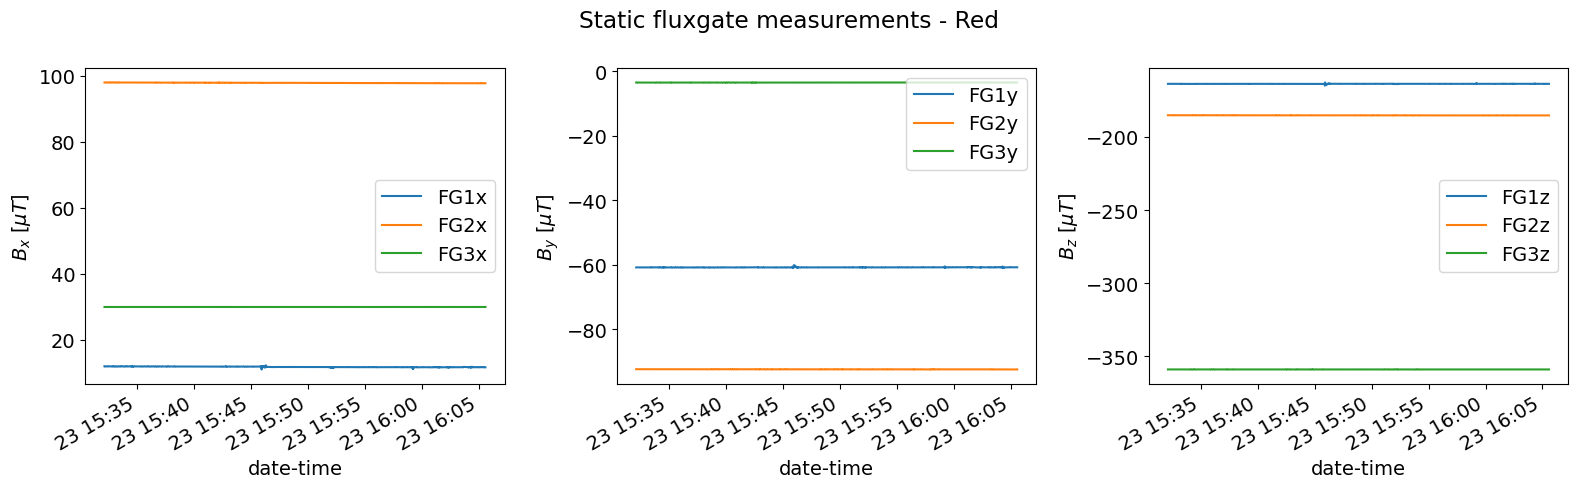

In [49]:
plt.rcParams['font.size'] = '14'

fig, axs = plt.subplots(1, 3, figsize=(16,5))
plt.suptitle("Static fluxgate measurements - Red")
# \n fluxgate coords (so y=-z, z=y)

q = list(dfRedSta.filter(like='x').columns)
q.append('Datetime')
dfRedSta.filter(items=q).plot(ax=axs[0], x=q[-1], y=q[:3])

q = list(dfRedSta.filter(like='y').columns)
q.append('Datetime')
# print(q[:3])
dfRedSta.filter(items=q).plot(ax=axs[1], x=q[-1], y=np.array(q[:3]))

q = list(dfRedSta.filter(like='z').columns)
q.append('Datetime')
dfRedSta.filter(items=q).plot(ax=axs[2], x=q[-1], y=q[:3])

axs[0].set_ylabel('$B_x$ [$\mu T$]')
axs[0].set_xlabel('date-time')

axs[1].set_ylabel('$B_y$ [$\mu T$]')
axs[1].set_xlabel('date-time')

axs[2].set_ylabel('$B_z$ [$\mu T$]')
axs[2].set_xlabel('date-time')

plt.tight_layout()
plt.savefig(f'plots/static_red.pdf', bbox_inches='tight')
plt.show()

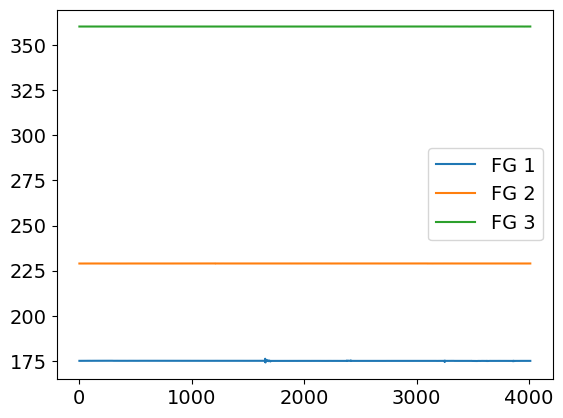

In [38]:
def Mag(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)

plt.plot(Mag(dfRedSta['FG1x'], dfRedSta['FG1y'], dfRedSta['FG1z'] ), label="FG 1")
plt.plot(Mag(dfRedSta['FG2x'], dfRedSta['FG2y'], dfRedSta['FG2z'] ), label='FG 2')
plt.plot(Mag(dfRedSta['FG3x'], dfRedSta['FG3y'], dfRedSta['FG3z'] ), label='FG 3')
plt.legend()
plt.show()

C:\Users\Emma\AppData\Local\Temp\ipykernel_20104\4114787563.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(fig)


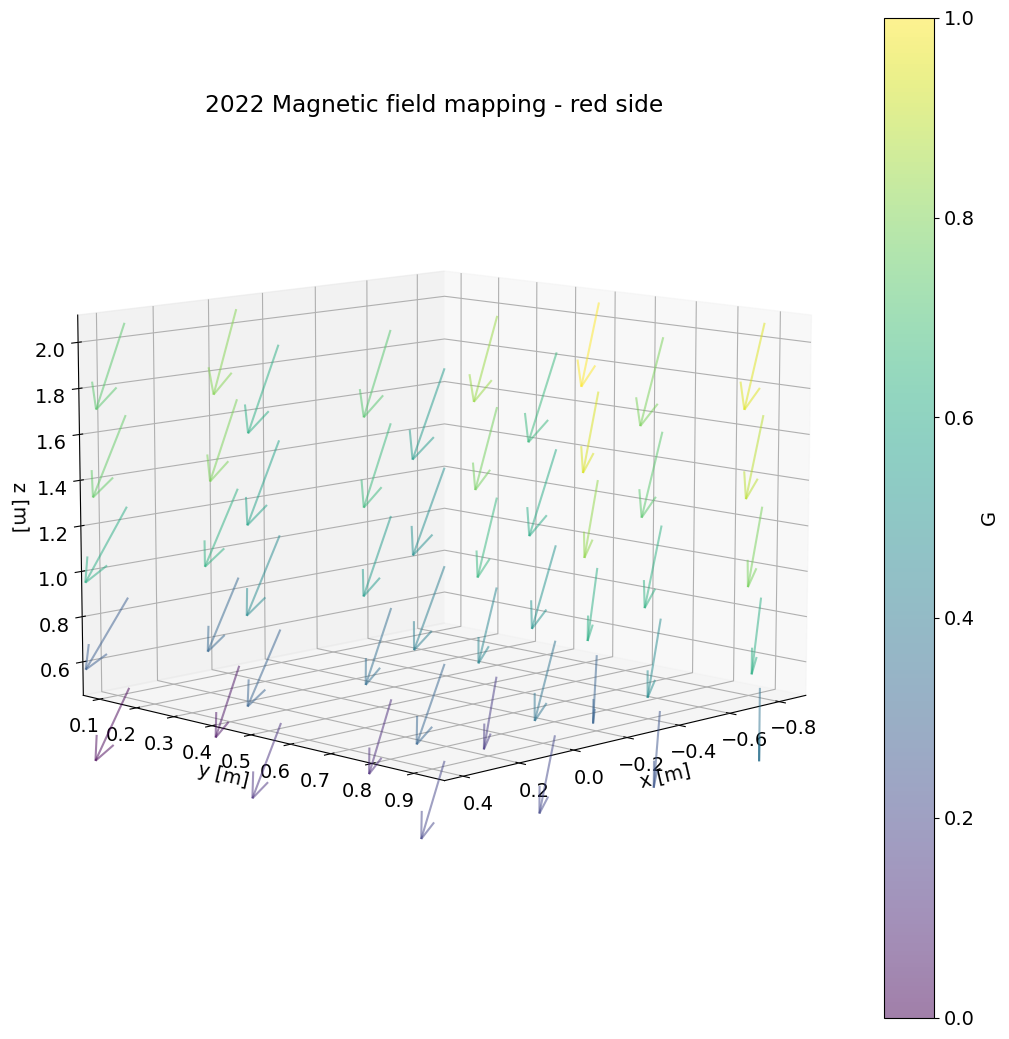

In [39]:
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

# axes.set_title("Electric Field for bias of 800 V", pad=-10)
plt.title("2022 Magnetic field mapping - red side", pad=-10)

x,y,z,Bx,By,Bz = returnVals(dfRed, 'no', [-200, 200], [-200, 200], )
c = np.sqrt(Bx**2+By**2+Bz**2)

# """
# Flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# # Repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))

c = plt.cm.viridis(c)
Q = axes.quiver(x/100,y/100,z/100, Bx,By,Bz, colors=c, length=.4, normalize=True, alpha=0.5)
cbar = fig.colorbar(Q, label="G")
    
axes.view_init(elev=10., azim=45)

axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')

plt.show()

## Now green board configuration

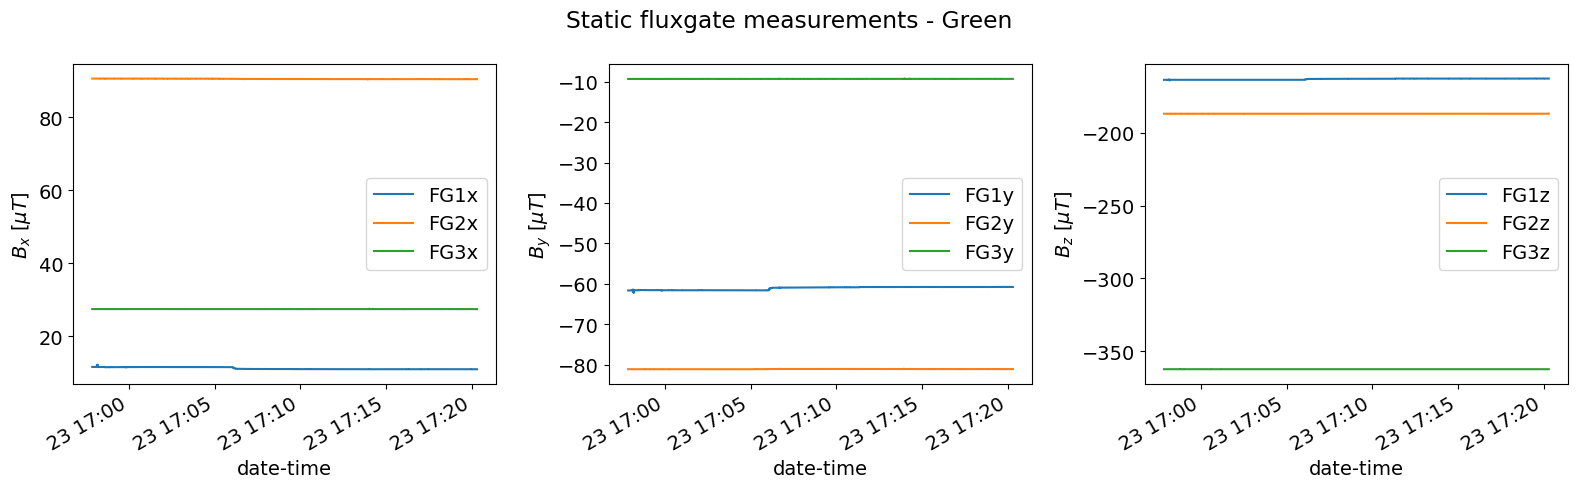

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
plt.suptitle("Static fluxgate measurements - Green")

q = list(dfGreenSta.filter(like='x').columns)
q.append('Datetime')
dfGreenSta.filter(items=q).plot(ax=axs[0], x=q[-1], y=q[:3])

q = list(dfGreenSta.filter(like='y').columns)
q.append('Datetime')
dfGreenSta.filter(items=q).plot(ax=axs[1], x=q[-1], y=q[:3])

q = list(dfGreenSta.filter(like='z').columns)
q.append('Datetime')
dfGreenSta.filter(items=q).plot(ax=axs[2], x=q[-1], y=q[:3])

axs[0].set_ylabel('$B_x$ [$\mu T$]')
axs[0].set_xlabel('date-time')

axs[1].set_ylabel('$B_y$ [$\mu T$]')
axs[1].set_xlabel('date-time')

axs[2].set_ylabel('$B_z$ [$\mu T$]')
axs[2].set_xlabel('date-time')

plt.tight_layout()
plt.savefig(f'plots/static_green.pdf', bbox_inches='tight')
plt.show()

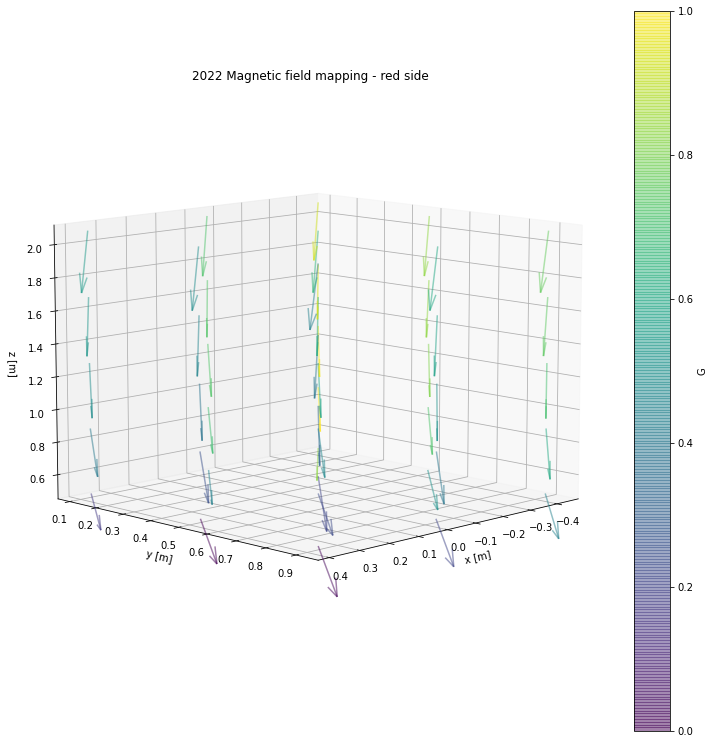

In [13]:
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

# axes.set_title("Electric Field for bias of 800 V", pad=-10)
plt.title("2022 Magnetic field mapping - red side", pad=-10)

x,y,z,Bx,By,Bz = returnVals(dfGreen, 'no', [-200, 200], [-200, 200], )
c = np.sqrt(Bx**2+By**2+Bz**2)

# """
# Flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# # Repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))

c = plt.cm.viridis(c)
Q = axes.quiver(x/100,y/100,z/100, Bx,By,Bz, colors=c, length=.4, normalize=True, alpha=0.5)
cbar = fig.colorbar(Q, label="G")
    
axes.view_init(elev=10., azim=45)

axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')

plt.show()

## Stairs data
uncorrected for offsets rn

In [55]:
#data in muT and cm
dfStair = pd.read_csv('Sept23_data/20220926_164800_RUN5.csv')
dfStair['datetime'] = pd.to_datetime(dfStair['datetime'], format='%Y%m%d_%H%M%S')

dfStairSta = pd.read_csv('Sept23_data/20220926_160856_platform_RUN5.csv')
dfStairSta['Datetime'] = pd.to_datetime(dfStairSta['Datetime'], format='%Y%m%d_%H%M%S')
dfStairSta = staticCoordTransf(dfStarirsSta)

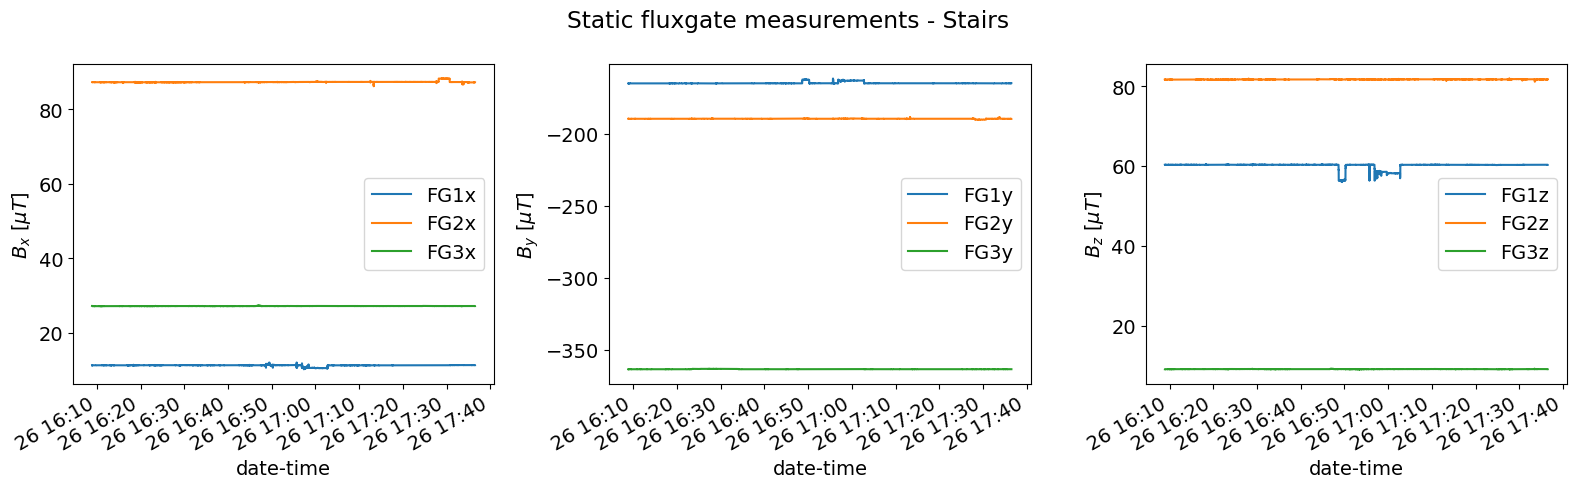

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
plt.suptitle("Static fluxgate measurements - Stairs")

q = list(dfStairSta.filter(like='x').columns)
q.append('Datetime')
dfStairSta.filter(items=q).plot(ax=axs[0], x=q[-1], y=q[:3])

q = list(dfStairSta.filter(like='y').columns)
q.append('Datetime')
dfStairSta.filter(items=q).plot(ax=axs[1], x=q[-1], y=q[:3])

q = list(dfStairSta.filter(like='z').columns)
q.append('Datetime')
dfStairSta.filter(items=q).plot(ax=axs[2], x=q[-1], y=q[:3])

axs[0].set_ylabel('$B_x$ [$\mu T$]')
axs[0].set_xlabel('date-time')

axs[1].set_ylabel('$B_y$ [$\mu T$]')
axs[1].set_xlabel('date-time')

axs[2].set_ylabel('$B_z$ [$\mu T$]')
axs[2].set_xlabel('date-time')

plt.tight_layout()
plt.savefig(f'plots/static_stairs.pdf', bbox_inches='tight')
plt.show()

C:\Users\Emma\AppData\Local\Temp\ipykernel_20104\2190425907.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(fig)


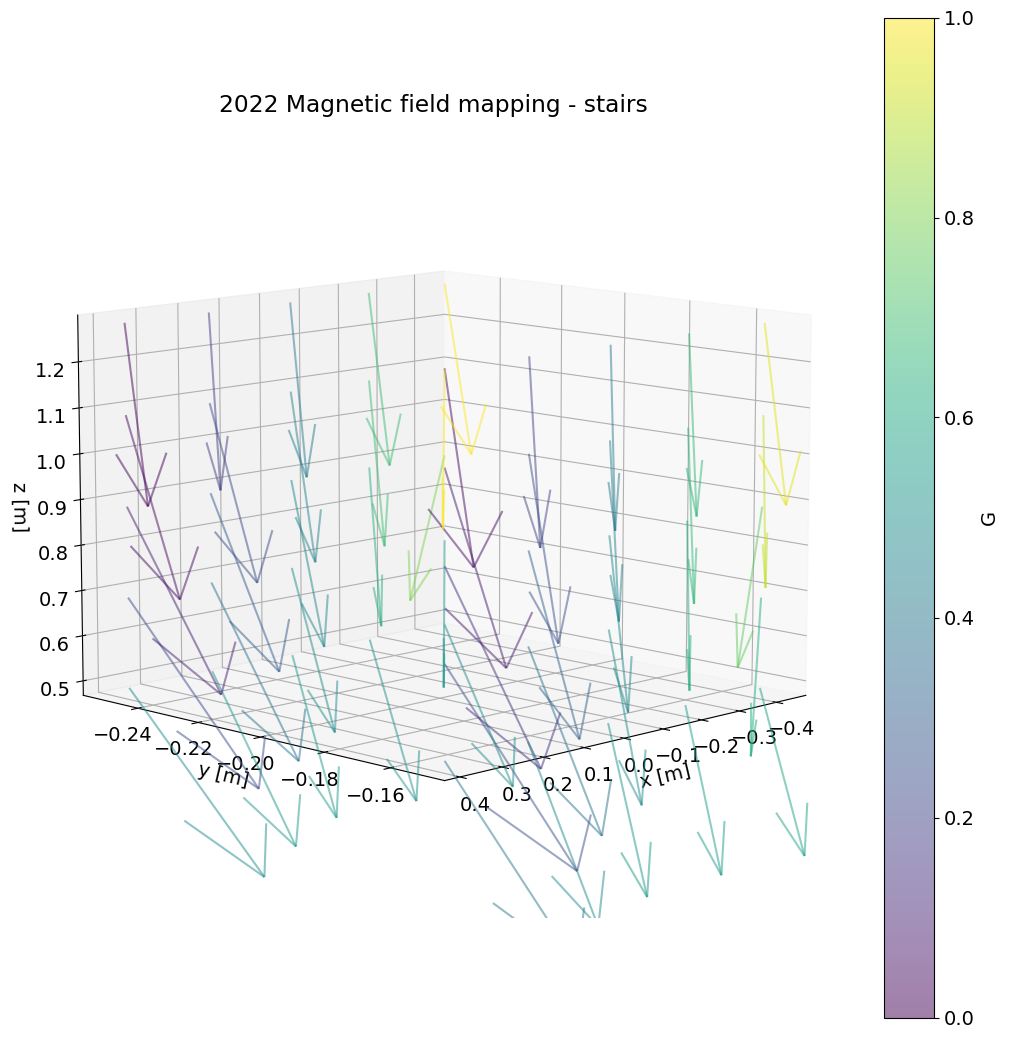

In [57]:
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

# axes.set_title("Electric Field for bias of 800 V", pad=-10)
plt.title("2022 Magnetic field mapping - stairs", pad=-10)

x,y,z,Bx,By,Bz = returnVals(dfStair, 'no', [-200, 200], [-200, 200], )
c = np.sqrt(Bx**2+By**2+Bz**2)

# """
# Flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# # Repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))

c = plt.cm.viridis(c)
Q = axes.quiver(x/100,y/100,z/100, Bx,By,Bz, colors=c, length=.4, normalize=True, alpha=0.5)
cbar = fig.colorbar(Q, label="G")
    
axes.view_init(elev=10., azim=45)

axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')

plt.show()

### Offset for stairs

In [3]:
u0 = 4*np.pi*1e-7 #T m/A

def B(n, I, R):
    return ((4/5)**(3/2) * u0 *n*I/R ) *1e6 #uT



In [7]:
B(15, 0.7, .6)

15.735584997531229